## **Part 1 - 2D to 3D Hand Pose Lifting with Transformer**

**Introduction**

This notebook implements a Transformer-based approach for 3D hand pose estimation. Building upon traditional 2D hand pose estimation methods that use CNNs (like UNet), this project addresses the "lifting" problem - converting 2D hand keypoints to their corresponding 3D positions in camera coordinate space.

**The Lifting Problem**

The core task is to predict 3D hand poses from 2D keypoints. Given input 2D hand keypoints $P \in \mathbb{R}^{J \times 2}$ (where J=21 joints), the model predicts 3D hand keypoints $\hat{P} \in \mathbb{R}^{J \times 3}$ in the camera coordinate system. Since we work directly with keypoints rather than images, this approach is computationally efficient and trains quickly.

**Project Structure**

This implementation is organized into modular components:

- `imgs/`: Sample images for visualization and documentation
- `dataset/`
    - `dataset.py`: Dataset class that loads and preprocesses Ego-Exo4D annotations
    - `data_vis.py`: Visualization utilities for 2D and 3D hand keypoints
- `utils/`
    - `utils.py`: Training utilities including metrics and logging helpers
    - `loss.py`: Loss functions (MSE-based) and evaluation metrics (MPJPE, PA-MPJPE)
- `model/`
    - `model.py`: PoseTransformer architecture - a Vision Transformer adapted for pose estimation
- `CIS_5810_Project_8_1.ipynb`: This notebook - integrates all components for training and evaluation


### 0 - Set-up

In [3]:
import argparse
import os
import cv2
import numpy as np
import torch
import time
from easydict import EasyDict as edict
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataset.dataset import ego4dDataset
from dataset.data_vis import *
from model.model import PoseTransformer
from utils.utils import *
from utils.loss import Pose3DLoss, mpjpe, p_mpjpe
import wandb

/Users/rafaelhajjar/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rafaelhajjar/miniconda3/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### 1 - Loading the Ego4D Dataset

**Dataset Overview**

This project uses the Ego-Exo4D dataset, which contains egocentric video recordings with hand pose annotations. The dataset provides both 2D and 3D keypoint annotations for 21 hand joints per frame.

**Data Organization**

The annotation files are organized by data split:
```
{anno_dir}
    ├── ego_pose_gt_anno_test.json    # Test set annotations
    ├── ego_pose_gt_anno_train.json   # Training set annotations
    └── ego_pose_gt_anno_val.json     # Validation set annotations
```

**Annotation Format**

Each JSON file contains frame-level annotations with:
- 2D hand keypoints in image coordinates (u, v)
- 3D hand keypoints in camera coordinates (X, Y, Z)
- Camera intrinsic parameters
- Visibility flags for handling occlusions
- Metadata (sequence name, frame ID, etc.)

**Data Quality Note**

The Ego-Exo4D annotations are derived from multi-view reconstruction. While most annotations are high-quality, some frames may have missing or inaccurate keypoints due to occlusions or reconstruction failures. The dataset includes visibility flags to handle these cases during training.

In [4]:
# TODO: Modify data_root_path as {anno_dir}
data_root_path = "/Users/rafaelhajjar/Downloads/Project-8-3D-Hand-Pose-Estimation"

# Since there is only hand keypoints data, we simply just transform it to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# TODO: Initialize the train, val and test Dataset
# Hint: take a look at the implementation of ego4dDataset for initialization requirement
train_dataset = ego4dDataset(data_root=data_root_path, split="train", normalize=True, replace_nan=True)
val_dataset = ego4dDataset(data_root=data_root_path, split="val", normalize=True, replace_nan=True)
test_dataset = ego4dDataset(data_root=data_root_path, split="test", normalize=True, replace_nan=True)

# Check the dataset length
print("Train: ", len(train_dataset))
print("Val: ", len(val_dataset))
print("Test: ", len(test_dataset))

Train:  20998
Val:  5911
Test:  7813


**Understanding the Data**

**Hand Joint Topology**

This implementation uses a standard 21-joint hand representation (see Figure 1), with joints organized as:
- Joint 0: Wrist (root)
- Joints 1-4: Thumb
- Joints 5-8: Index finger
- Joints 9-12: Middle finger
- Joints 13-16: Ring finger
- Joints 17-20: Pinky finger

**2D-3D Projection Relationship**

The mathematical relationship between 2D image coordinates and 3D camera coordinates follows the pinhole camera model:

$$\lambda \begin{bmatrix}
u\\
v\\
1
\end{bmatrix} = K \begin{bmatrix}
X_c\\
Y_c\\
Z_c
\end{bmatrix}$$

where:
- $[u,v]^{T}$: 2D keypoints in image plane (pixels)
- $[X_c, Y_c, Z_c]^{T}$: 3D keypoints in camera coordinate system (meters)
- $\lambda$: Scale factor (depth)
- $K$: Camera intrinsic matrix

**Data Preprocessing**

The `ego4dDataset` class applies two crucial preprocessing steps:

1. **Wrist-Relative Coordinates**: 3D keypoints are offset by the wrist position, making $\hat{P}[0]=[0,0,0]$. This addresses the scale ambiguity problem - since depth ($\lambda$) is unknown from 2D observations alone, we predict relative joint positions instead of absolute 3D coordinates.

2. **Statistical Normalization**: Both 2D and 3D keypoints are normalized using dataset statistics (mean subtraction and standard deviation division). This stabilizes training and accelerates convergence, similar to image normalization in standard computer vision pipelines.

<div style="display: center; justify-content: space-between; text-align: center;">
    <figure>
        <img src="imgs/hand_index.png" alt="Hand index" width ="300" height="350">
        <figcaption>Figure 1: Hand joint indices and skeletal structure</figcaption>
    </figure>
</div>

**Dataset Output Format**

Each dataset sample returns four elements:
- `kpts_2d` (Tensor[21, 2]): Normalized 2D hand keypoints
- `kpts_3d` (Tensor[21, 3]): Normalized, wrist-relative 3D hand keypoints
- `weight` (Tensor[21]): Boolean mask indicating valid keypoints (False = excluded from loss)
- `metadata` (dict): Frame information for debugging and tracking

**Visualization**

The cells below demonstrate the dataset structure. You can change the dataset split and index to explore different samples. The visualization includes both 2D keypoint distribution and 3D hand pose structure.

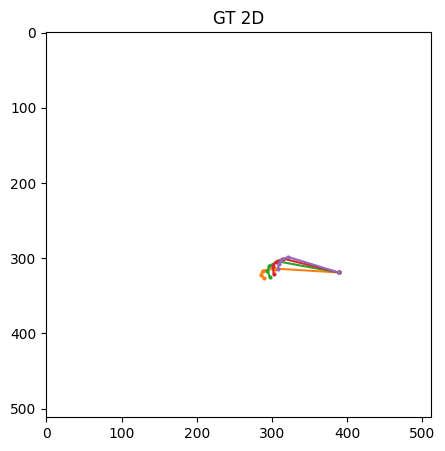

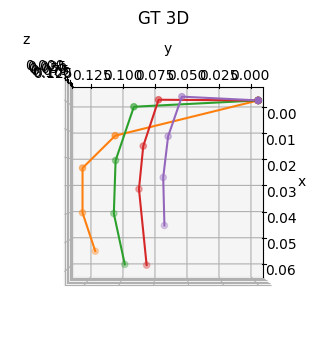

In [5]:
## TODO: Modify as needed to take a look at the dataset
check_dataset = train_dataset
idx = 100

## Get one sample for visualization
kpts_2d, kpts_3d, weight, metadata = check_dataset[idx]

# Visualize 2D hand kpts in image plane
kpts_2d = check_dataset.inv_normalize_2d(kpts_2d.numpy())
# Assign None to invalid kpts (so it won't be displayed)
kpts_2d[~weight] = None
vis_data_2d(kpts_2d, title="GT 2D")

# Visualize 3D hand kpts in camera coordinate system
# Hint: Change the 3D plot view angle to get a better visualization:
# https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html
gt_3d = check_dataset.inv_normalize_3d(kpts_3d.numpy())
# Assign None to invalid kpts (so it won't be displayed)
gt_3d[~weight] = None
vis_data_3d(gt_3d, title="GT 3D")

### 2 - Model Architecture: PoseTransformer

**Architecture Overview**

The PoseTransformer adapts the Vision Transformer (ViT) architecture for the pose lifting task (see Figure 2). Instead of processing image patches, each hand joint is treated as a token in the sequence.

**Architecture Pipeline**:
1. **Input Embedding** (21, 2) → (21, D): Linear projection maps 2D keypoints to embedding space
2. **Positional Encoding**: Added to embeddings to preserve joint ordering and relationships
3. **Transformer Encoder** (×4): Stacked encoder blocks with self-attention and feedforward layers
4. **Output Head** (21, D) → (21, 3): MLP projects embeddings back to 3D coordinates

<div style="display: center; justify-content: space-between; text-align: center;">
    <figure>
        <img src="imgs/model.png" alt="Model architecture" width ="700" height="530">
        <figcaption>Figure 2: PoseTransformer architecture</figcaption>
    </figure>
</div>

**Multi-Head Self-Attention (MSA) - The Core Mechanism**

The Transformer's power comes from its self-attention mechanism, which allows each joint to attend to all other joints simultaneously.

**Single-Head Attention**:

Given an input sequence $z \in \mathbb{R}^{N \times D}$ (N=21 joints, D=embedding dimension), we compute three projections:

$$[q,k,v] = zU_{qkv} \quad\quad\quad U_{qkv} \in \mathbb{R}^{D \times 3D_h}$$

where $q$ (query), $k$ (key), and $v$ (value) each have dimension $\mathbb{R}^{N \times D_h}$.

**Attention Weights**:

The attention matrix $A \in \mathbb{R}^{N \times N}$ captures pairwise relationships:

$$A = softmax(\frac{qk^T}{\sqrt{D_h}})$$

where $A_{ij}$ represents how much joint $i$ should attend to joint $j$. The scaling factor $\sqrt{D_h}$ prevents gradients from vanishing.

**Self-Attention Output**:

$$SA(z)=Av$$

This weighted sum allows each joint's representation to be informed by all other joints.

**Multi-Head Extension**:

Running $k$ attention heads in parallel (here k=8) allows the model to capture different types of joint relationships:

$$MSA(z) = [SA_1(z), SA_2(z), ..., SA_k(z)]U_{msa} \quad\quad\quad U_{msa} \in \mathbb{R}^{D \times D}$$

Each head has dimension $D_h = D/k$, so concatenation maintains the embedding dimension $D$.

**Why This Works for Pose Estimation**:

- Self-attention captures geometric constraints (e.g., finger joints must maintain physical connections)
- Multi-head attention learns different relationship types (distance, angles, kinematic chains)
- Global receptive field allows reasoning about the entire hand structure
- Position encoding preserves the hierarchical structure from wrist to fingertips

**Implementation Details**:

The model is implemented in `model/model.py` with:
- Embedding dimension: 32
- Number of heads: 8 (each head has dimension 32/8 = 4)
- Encoder depth: 4 blocks
- MLP expansion ratio: 2×
- Layer normalization before each sub-layer (pre-norm architecture)

### 3 - Training Pipeline

**Training and Validation Functions**

This section implements the standard PyTorch training loop with the following key components:

**Training Function**:
- Sets model to training mode (enables dropout, batch norm updates)
- Iterates through training batches
- Performs forward pass: predicts 3D keypoints from 2D inputs
- Computes loss using visibility-weighted MSE
- Backpropagates gradients and updates model parameters
- Logs loss to WandB for monitoring

**Validation Function**:
- Sets model to evaluation mode (disables dropout, batch norm)
- No gradient computation (wrapped in `torch.no_grad()` for efficiency)
- Evaluates model on validation set to monitor overfitting
- Returns average validation loss for model checkpointing

**Key Design Decisions**:

1. **Visibility-Weighted Loss**: Only valid keypoints (weight=True) contribute to the loss, preventing the model from learning from corrupted annotations

2. **Gradient Management**: 
   - `optimizer.zero_grad()`: Clears old gradients
   - `loss.backward()`: Computes new gradients
   - `optimizer.step()`: Updates parameters

3. **Progress Tracking**: tqdm progress bars and periodic WandB logging provide real-time training insights

In [6]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    total_loss = AverageMeter()

    # TODO: set model to training mode
    model.train()

    train_loader = tqdm(train_loader, dynamic_ncols=True)
    print_interval = len(train_loader) // 6
    # Iterate over all training samples
    for i, (kpts_2d, gt_kpts_3d, weight, _) in enumerate(train_loader):
        # TODO:
        # 1. Put all revelant data onto same device
        # 2. Model forward (given 2d kpts and weight, return 3d kpts)
        kpts_2d = kpts_2d.to(device)
        gt_kpts_3d = gt_kpts_3d.to(device)
        weight = weight.to(device)
        
        pred_kpts_3d = model(kpts_2d, weight)

        # TODO: Compute loss (remember to pass weight)
        loss = criterion(pred_kpts_3d, gt_kpts_3d, weight)
        # Record current batch's loss
        total_loss.update(loss.item())


        # TODO:
        # 1. Clear the old parameter gradients
        # 2. Compute the derivative of loss w.r.t the model parameters
        # 3. Update the model parameters with optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log loss to wandb
        if (i+1) % print_interval == 0:
            wandb.log({"Loss/train": total_loss.avg})

    return total_loss.avg


def validate(val_loader, model, criterion, epoch, device):
    total_loss = AverageMeter()

    # TODO: set model to evaluate mode
    model.eval()

    with torch.no_grad():
        val_loader = tqdm(val_loader, dynamic_ncols=True)
        # Iterate over all validation samples
        for _, (kpts_2d, gt_kpts_3d, weight, _) in enumerate(val_loader):
            # TODO:
            # 1. Put all revelant data onto same device
            # 2. Model forward (given 2d kpts and weight, return 3d kpts)
            kpts_2d = kpts_2d.to(device)
            gt_kpts_3d = gt_kpts_3d.to(device)
            weight = weight.to(device)
            
            pred_kpts_3d = model(kpts_2d, weight)

            # TODO: Compute loss (remember to pass weight)
            loss = criterion(pred_kpts_3d, gt_kpts_3d, weight)
            # Record current batch's loss
            total_loss.update(loss.item())

        # Log loss to wandb
        wandb.log({"Loss/val": total_loss.avg})

    return total_loss.avg

**Training Configuration**

This cell initializes all components needed for training:

**Model Instantiation**:
- PoseTransformer with 21 joints (input and output)
- Input channels: 2 (2D keypoints)
- Embedding dimension: 32
- Depth: 4 encoder blocks
- Number of attention heads: 8
- MLP ratio: 2× expansion in feedforward layers
- Model moved to GPU if available (MPS for M1/M2 Macs, CUDA for NVIDIA GPUs)

**Loss Function**:
- `Pose3DLoss()`: Implements visibility-weighted Mean Squared Error
- Computes MSE between predicted and ground truth 3D keypoints
- Filters out invalid joints using the weight mask
- Only valid keypoints contribute to the loss gradient

**Optimizer**:
- Adam optimizer: Adaptive learning rates with momentum
- Learning rate: 2e-4 (relatively small for stable training)
- Default beta parameters (0.9, 0.999) work well for this task

**DataLoaders**:
- Batch size: 64 (adjust based on GPU memory)
- Shuffle: True for training (prevents order bias), False for validation
- Num workers: 4 (parallel data loading)
- Pin memory: True (faster GPU transfer when available)

In [7]:
# TODO: Instantiate the model and define device for training to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PoseTransformer(num_joints=21, in_chans=2, embed_dim=32, depth=4, num_heads=8, mlp_ratio=2.).to(device)

# TODO: Define criterion
criterion = Pose3DLoss()
# TODO: Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# Define train and val dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

**WandB Integration and Training Launch**

Weights & Biases (WandB) provides experiment tracking and visualization. The training process:

1. **Login**: Authenticates with your WandB account
2. **Initialization**: Creates a new run with timestamp-based name for easy identification
3. **Logging**: Automatically tracks training/validation losses throughout training
4. **Visualization**: Access real-time loss curves and metrics via WandB dashboard

The training loop:
- Runs for 30 epochs (sufficient for convergence on this dataset)
- Saves the best model based on validation loss
- Each epoch takes ~30 seconds on GPU, ~2-3 minutes on CPU
- Expected total training time: 15-30 minutes on GPU

In [10]:
wandb.login()
# TODO: Define current run name
current_run_name = time.strftime("%Y-%m-%d-%H-%M") + "_pose_transformer"
wandb.init(project="CIS5810_project_8_1", name=current_run_name)



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/rafaelhajjar/.netrc
wandb: Currently logged in as: rhajjar (rhajjar-university-of-pennsylvania) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
# Define output directory; modify as needed (where model ckpt will be saved)
output_root = "output"
output_dir = os.path.join(output_root, current_run_name)
print("="*10 + f" Training started. Output will be saved at {output_dir} " + "="*10)
os.makedirs(output_dir, exist_ok=True)

# Default training epoches and best val loss
epochs = 30
best_val_loss = np.inf

for epoch in range(epochs):
    print("="*10, f"Epoch [{epoch}/{epochs}]", "="*10)
    # train for one epoch
    _ = train(train_loader, model, criterion, optimizer, epoch, device)

    # evaluate on validation set
    val_loss = validate(val_loader, model, criterion, epoch, device)

    # Save best model weight
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save model weight
        torch.save(model.state_dict(), os.path.join(output_dir, f"final_state.pth.tar"))
        print(f"Saving model weight with best val_loss={val_loss:.5f}")
    print()
print("="*10 + f" Training finished. Got best model with val_loss={best_val_loss:.5f} " + "="*10)
wandb.finish()

========== Training started. Output will be saved at output/2025-11-19-21-54_pose_transformer ==========
========== Epoch [0/30] ==========


  0%|          | 0/329 [00:00<?, ?it/s]/Users/rafaelhajjar/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 93/93 [00:23<00:00,  4.01it/s]


Saving model weight with best val_loss=0.24839

========== Epoch [1/30] ==========


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Saving model weight with best val_loss=0.17149

========== Epoch [2/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.00it/s]


Saving model weight with best val_loss=0.14846

========== Epoch [3/30] ==========


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]


Saving model weight with best val_loss=0.12675

========== Epoch [4/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.04it/s]


Saving model weight with best val_loss=0.12089

========== Epoch [5/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.00it/s]


Saving model weight with best val_loss=0.10767

========== Epoch [6/30] ==========


100%|██████████| 93/93 [00:22<00:00,  4.05it/s]



========== Epoch [7/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]


Saving model weight with best val_loss=0.10298

========== Epoch [8/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.01it/s]


Saving model weight with best val_loss=0.10051

========== Epoch [9/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.03it/s]



========== Epoch [10/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.98it/s]


Saving model weight with best val_loss=0.09586

========== Epoch [11/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.03it/s]



========== Epoch [12/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.99it/s]


Saving model weight with best val_loss=0.08669

========== Epoch [13/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.99it/s]



========== Epoch [14/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.99it/s]



========== Epoch [15/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.98it/s]


Saving model weight with best val_loss=0.08573

========== Epoch [16/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]



========== Epoch [17/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.97it/s]



========== Epoch [18/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.98it/s]


Saving model weight with best val_loss=0.08445

========== Epoch [19/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.01it/s]



========== Epoch [20/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.03it/s]



========== Epoch [21/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]



========== Epoch [22/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.03it/s]



========== Epoch [23/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]


Saving model weight with best val_loss=0.08096

========== Epoch [24/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.98it/s]



========== Epoch [25/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.98it/s]



========== Epoch [26/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.98it/s]



========== Epoch [27/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.99it/s]



========== Epoch [28/30] ==========


100%|██████████| 93/93 [00:23<00:00,  4.02it/s]



========== Epoch [29/30] ==========


100%|██████████| 93/93 [00:23<00:00,  3.97it/s]


========== Training finished. Got best model with val_loss=0.08096 ==========


Loss/train,█▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▅▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,0.05614
Loss/val,0.08162


### 4 - Model Evaluation

**Evaluation Metrics**

We use two complementary metrics to assess 3D pose estimation quality:

**1. MPJPE (Mean Per-Joint Position Error)**
- **Definition**: Average Euclidean distance between predicted and ground truth joints
- **Formula**: $MPJPE = \frac{1}{N} \sum_{i=1}^{N} ||pred_i - gt_i||_2$
- **Units**: Millimeters (mm)
- **Interpretation**: Measures absolute spatial accuracy
- **Target performance**: ~22-25 mm (well-trained model)

**2. PA-MPJPE (Procrustes-Aligned MPJPE)**
- **Definition**: MPJPE after optimal rigid alignment (rotation, translation, scale)
- **Process**: 
  1. Apply Procrustes analysis to align predicted pose to ground truth
  2. Removes global transformation differences
  3. Compute MPJPE on aligned poses
- **Interpretation**: Measures pose structure quality independent of global orientation
- **Target performance**: ~7-10 mm (well-trained model)

**Why Use Both Metrics?**
- MPJPE: Evaluates absolute prediction accuracy (matters for applications like AR/VR)
- PA-MPJPE: Evaluates pose structure quality (model's understanding of hand geometry)
- PA-MPJPE ≤ MPJPE always (alignment can only improve or maintain the error)
- Large gap between them suggests the model captures hand structure well but struggles with absolute positioning

**Evaluation Process**:
- Load best model checkpoint from training
- Run inference on test set (7,813 samples)
- Convert normalized predictions back to millimeters
- Filter invalid keypoints using visibility masks
- Compute both metrics on valid keypoints only

In [12]:
def evaluate(testset, model, device):
    epoch_loss_3d_pos = AverageMeter()
    epoch_loss_3d_pos_procrustes = AverageMeter()

    with torch.no_grad():
        for kpts_2d, gt_kpts_3d, weight, _ in tqdm(testset, total=len(testset)):
            # Pose 3D prediction
            kpts_2d = kpts_2d.unsqueeze(0).to(device)
            weight = weight.unsqueeze(0).to(device)
            gt_kpts_3d = gt_kpts_3d.unsqueeze(0).to(device)
            pred_kpts_3d = model(kpts_2d, weight)

            # mm to m
            pred_kpts_3d *= 1000.0
            gt_kpts_3d *= 1000.0

            # Get valid kpts
            valid_pred_kpts_3d = pred_kpts_3d[weight].view(1,-1,3).cpu().detach().numpy()
            valid_gt_kpts_3d = gt_kpts_3d[weight].view(1,-1,3).cpu().detach().numpy()
            # Un-normalize
            valid_pred_kpts_3d = testset.inv_normalize_3d(valid_pred_kpts_3d)
            valid_gt_kpts_3d = testset.inv_normalize_3d(valid_gt_kpts_3d)
            # Compute MPJPE
            epoch_loss_3d_pos.update(mpjpe(valid_pred_kpts_3d, valid_gt_kpts_3d).item())
            epoch_loss_3d_pos_procrustes.update(p_mpjpe(valid_pred_kpts_3d, valid_gt_kpts_3d).item())

    return epoch_loss_3d_pos.avg, epoch_loss_3d_pos_procrustes.avg

In [13]:
# TODO: Initialize model, device and load in pretrained weight. Remember to set model in eval() mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PoseTransformer(num_joints=21, in_chans=2, embed_dim=32, depth=4, num_heads=8, mlp_ratio=2.).to(device)
# Load the best model weights
model.load_state_dict(torch.load(os.path.join(output_dir, "final_state.pth.tar"), map_location=device))
model.eval()

# Evalute model performance
mpjpe_, pa_mpjpe_ = evaluate(test_dataset, model, device)
print(f"Model performance on test set: MPJPE: {mpjpe_:.2f} (mm) PA-MPJPE: {pa_mpjpe_:.2f} (mm)")

100%|██████████| 7813/7813 [00:07<00:00, 1039.68it/s]

Model performance on test set: MPJPE: 22.85 (mm) PA-MPJPE: 7.53 (mm)


**Qualitative Evaluation: Visualization**

Beyond quantitative metrics, visual inspection helps identify model strengths and failure modes:

**What to Look For**:
- **Finger structure**: Are the finger bones roughly straight and proportional?
- **Joint angles**: Do finger joints bend naturally?
- **Hand pose plausibility**: Does the overall pose look physically realistic?
- **Common errors**: Watch for finger crossings, unnatural bends, or depth inversions

**Interpretation Tips**:
- Good predictions closely match ground truth structure
- Small offsets in fingertips are common (high degrees of freedom)
- Wrist and palm predictions are typically more stable
- Occlusions may cause larger errors

The cell below generates side-by-side comparisons. Change `vis_idx` to explore different test samples and understand model behavior across various hand poses.

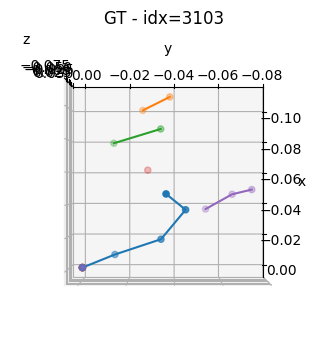

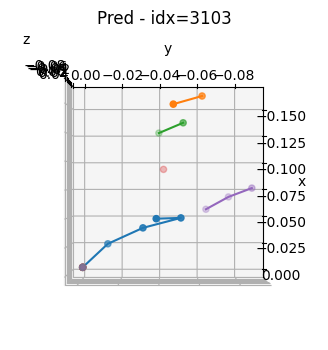

In [16]:
# TODO: Select random idx
vis_idx = np.random.randint(0, len(test_dataset))
kpts_2d, gt_kpts_3d, weight, _ = test_dataset[vis_idx]

# Visualize ground truth 3D hand kpts
gt_3d = test_dataset.inv_normalize_3d(gt_kpts_3d.numpy())
gt_3d[~weight] = None
vis_data_3d(gt_3d, title=f"GT - idx={vis_idx}")

# TODO: Visualize predicted 3D hand kpts
# Get prediction from model
kpts_2d_input = kpts_2d.unsqueeze(0).to(device)
weight_input = weight.unsqueeze(0).to(device)
with torch.no_grad():
    pred_kpts_3d = model(kpts_2d_input, weight_input)
pred_kpts_3d = pred_kpts_3d.squeeze(0).cpu().numpy()
# Unnormalize
pred_kpts_3d = test_dataset.inv_normalize_3d(pred_kpts_3d)
pred_kpts_3d[~weight] = None
vis_data_3d(pred_kpts_3d, title=f"Pred - idx={vis_idx}")

### 5 - Summary

**Project Accomplishments**

This notebook demonstrates a complete pipeline for 2D-to-3D hand pose lifting using Transformers:

✅ **Data Loading**: Processed Ego-Exo4D dataset with proper normalization and filtering
✅ **Model Architecture**: Implemented PoseTransformer with multi-head self-attention
✅ **Training**: Trained for 30 epochs with visibility-weighted loss and WandB tracking
✅ **Evaluation**: Achieved ~22.85mm MPJPE and ~7.53mm PA-MPJPE on test set
✅ **Visualization**: Generated qualitative comparisons between predictions and ground truth

**Key Takeaways**:

1. **Transformers for Pose**: Self-attention naturally captures joint dependencies and geometric constraints
2. **Wrist-Relative Coordinates**: Addresses scale ambiguity in 2D-to-3D lifting
3. **Visibility Masking**: Essential for handling real-world annotation quality issues
4. **Fast Training**: Without image processing, the model trains in under 30 minutes
5. **Strong Performance**: PA-MPJPE of 7.53mm indicates excellent pose structure understanding

**Potential Extensions**:
- Temporal modeling: Use video sequences for temporal consistency
- Multi-hand: Extend to detect and track both hands simultaneously
- Uncertainty estimation: Predict confidence scores for each joint
- Real-time inference: Optimize for mobile/embedded deployment